In [ ]:
import pandas as pd
import re
import html
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from transformers import AlbertForSequenceClassification, AlbertTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import time
import os

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, RobertaTokenizer, AlbertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import re
import html

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    #Veri setindeki toplam örnek sayısı
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length, #Maksimum token sayısını belirler
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


    def clean_text(text):
        if pd.isnull(text):
            return ""
        text = html.unescape(text)
        text = re.sub(r'#\d+;', '', text) #HTML karakterlerini (&amp;) çözer
        text = re.sub(r'<[^>]+>', ' ', text) #HTML tag’lerini siler (<br>, <p> vs.)
        text = re.sub(r'http\S+|www\.\S+', '', text) #URL’leri siler
        text = re.sub(r'\\[a-zA-Z]', ' ', text) #kaçış karakterlerini temizle
        text = re.sub(r'\s+', ' ', text).strip() #Gereksiz whitespace’leri temizler

        return text

    # CSV'leri yükle
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")

    # Text verilerini temizle
    train_df["cleaned_text"] = train_df["text"].apply(clean_text)
    test_df["cleaned_text"] = test_df["text"].apply(clean_text)

    print(train_df.head())

    train_df.to_csv("train_cleaned.csv", index=False)
    test_df.to_csv("test_cleaned.csv",index=False)

def save_to_csv(texts, labels, filename):
    df = pd.DataFrame({
        'text': texts,
        'label': labels
    })
    df.to_csv(filename, index=False)
    print(f"Saved to {filename}")

def analyze_dataset(df, name):
    print(f"\nAnalyzing {name} dataset:")
    print(f"Total rows: {len(df)}")
    print(f"Missing values in text: {df['text'].isna().sum()}")
    print(f"Missing values in label: {df['label'].isna().sum()}")
    print(f"Unique labels: {df['label'].unique()}")
    print(f"Label distribution:\n{df['label'].value_counts()}")

def load_and_preprocess_data(train_path, test_path, model_name='bert-base-uncased'):
    processed_dir = f'processed_data/{model_name}'
    os.makedirs(processed_dir, exist_ok=True)

    # Verileri yükle
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    train_df.columns = ['text', 'label']
    test_df.columns = ['text', 'label']

    analyze_dataset(train_df, "Original Training")
    analyze_dataset(test_df, "Original Test")

    # Eksik değerleri empty string ile doldur
    train_df['text'] = train_df['text'].fillna('')
    test_df['text'] = test_df['text'].fillna('')

    # Convert labels to integers (preserving all labels 0-3)
    train_df['label'] = train_df['label'].astype(int)
    test_df['label'] = test_df['label'].astype(int)

    analyze_dataset(train_df, "After Label Conversion Training")
    analyze_dataset(test_df, "After Label Conversion Test")

    # Train validation ayrımı
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['text'].values,
        train_df['label'].values,
        test_size=0.1,
        random_state=42
    )

    save_to_csv(train_texts, train_labels, f'{processed_dir}/train.csv')
    save_to_csv(val_texts, val_labels, f'{processed_dir}/val.csv')
    save_to_csv(test_df['text'].values, test_df['label'].values, f'{processed_dir}/test.csv')

    # Initialize appropriate tokenizer based on model
    if 'roberta' in model_name.lower():
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
    elif 'albert' in model_name.lower():
        tokenizer = AlbertTokenizer.from_pretrained(model_name)
    else:  # Default to BERT
        tokenizer = BertTokenizer.from_pretrained(model_name)

    # Datasetlerini oluşturma
    train_dataset = TextDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    test_dataset = TextDataset(test_df['text'].values, test_df['label'].values, tokenizer)

    # DataLoaders oluşturma
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    return train_loader, val_loader, test_loader, tokenizer

def load_processed_data(model_name):
    processed_dir = f'processed_data/{model_name}'

    train_df = pd.read_csv(f'{processed_dir}/train.csv')
    val_df = pd.read_csv(f'{processed_dir}/val.csv')
    test_df = pd.read_csv(f'{processed_dir}/test.csv')

    # Initialize tokenizer
    if 'roberta' in model_name.lower():
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
    elif 'albert' in model_name.lower():
        tokenizer = AlbertTokenizer.from_pretrained(model_name)
    else:  # Default to BERT
        tokenizer = BertTokenizer.from_pretrained(model_name)

    # Datasetlerini oluşturma
    train_dataset = TextDataset(train_df['text'].values, train_df['label'].values, tokenizer)
    val_dataset = TextDataset(val_df['text'].values, val_df['label'].values, tokenizer)
    test_dataset = TextDataset(test_df['text'].values, test_df['label'].values, tokenizer)

    # DataLoaders oluşturma
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    return train_loader, val_loader, test_loader

if __name__ == "__main__":
    model_names = [
        'bert-base-uncased',
        'bert-large-uncased',
        'roberta-base',
        'albert-base-v2'
    ]

    for model_name in model_names:
        print(f"\nProcessing data for {model_name}")
        train_loader, val_loader, test_loader, tokenizer = load_and_preprocess_data(
            'train.csv',
            'test.csv',
            model_name
        )
        print(f"Number of training batches: {len(train_loader)}")
        print(f"Number of validation batches: {len(val_loader)}")
        print(f"Number of test batches: {len(test_loader)}")

                                                text  label  \
0  Wall St. Bears Claw Back Into the Black (Reute...      2   
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2   
3  Iraq Halts Oil Exports from Main Southern Pipe...      2   
4  Oil prices soar to all-time record, posing new...      2   

                                        cleaned_text  
0  Wall St. Bears Claw Back Into the Black (Reute...  
1  Carlyle Looks Toward Commercial Aerospace (Reu...  
2  Oil and Economy Cloud Stocks' Outlook (Reuters...  
3  Iraq Halts Oil Exports from Main Southern Pipe...  
4  Oil prices soar to all-time record, posing new...  

Processing data for bert-base-uncased

Analyzing Original Training dataset:
Total rows: 120000
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Analyzing Original T

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Number of training batches: 6750
Number of validation batches: 750
Number of test batches: 475

Processing data for bert-large-uncased

Analyzing Original Training dataset:
Total rows: 120000
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Analyzing Original Test dataset:
Total rows: 7600
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64

Analyzing After Label Conversion Training dataset:
Total rows: 120000
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Analyzing After Label Conversion Test dataset:
Total rows: 7600
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Number of training batches: 6750
Number of validation batches: 750
Number of test batches: 475

Processing data for roberta-base

Analyzing Original Training dataset:
Total rows: 120000
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Analyzing Original Test dataset:
Total rows: 7600
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64

Analyzing After Label Conversion Training dataset:
Total rows: 120000
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Analyzing After Label Conversion Test dataset:
Total rows: 7600
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Number of training batches: 6750
Number of validation batches: 750
Number of test batches: 475

Processing data for albert-base-v2

Analyzing Original Training dataset:
Total rows: 120000
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Analyzing Original Test dataset:
Total rows: 7600
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64

Analyzing After Label Conversion Training dataset:
Total rows: 120000
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Analyzing After Label Conversion Test dataset:
Total rows: 7600
Missing values in text: 0
Missing values in label: 0
Unique labels: [2 3 1 0]
Label distribution:
label
2  

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Number of training batches: 6750
Number of validation batches: 750
Number of test batches: 475


In [ ]:
def word_cloud_quick(data):
    """
    Generate a word cloud from the text data.
    A word cloud is a visualization technique that displays the most frequent words in a text corpus. The size of each
    word in the word cloud is proportional to its frequency in the text data.

    Quick version of the word cloud function that takes a list of strings as input.

    :param data: List of strings containing the text data.
    :return: None
    """
    print("Generating Word Cloud")

    # Generate word cloud from the text data
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_font_size=80,
        colormap='viridis',
        contour_color='black',
        contour_width=1,
        prefer_horizontal=0.7
    ).generate(' '.join(data))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: text, Length: 120000, dtype: object
Generating Word Cloud


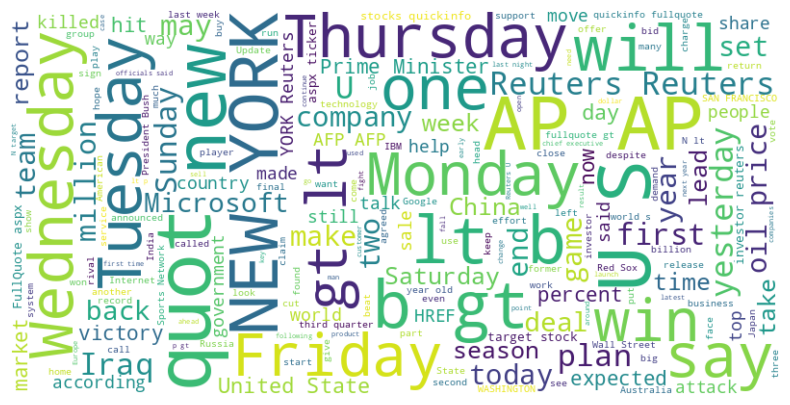

In [ ]:
train_df = pd.read_csv("train.csv")

data = train_df["text"]
print(data)


word_cloud_quick(data)

Generating Word Cloud


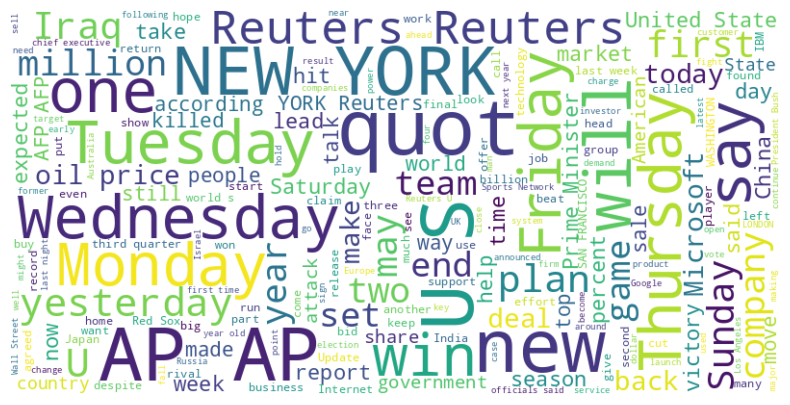

In [ ]:
train_df = pd.read_csv("train_cleaned.csv")

data = train_df["cleaned_text"]

word_cloud_quick(data)

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report

models_info = {
    'roberta-base': (RobertaTokenizer, RobertaForSequenceClassification),
    'albert-base-v2': (AlbertTokenizer, AlbertForSequenceClassification),
}

def train_model(model, train_loader, val_loader, device, model_name, num_epochs=3):
    optimizer = AdamW(model.parameters(), lr=2e-5) # AdamW optimizasyon algoritmasını kullanır
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup( #Öğrenme oranını eğitim boyunca dinamik olarak ayarlar.
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    best_accuracy = 0
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs} - {model_name}')
        print('-' * 10)

        # Training
        model.train()
        total_train_loss = 0
        train_preds = []
        train_labels = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss # Kaybı alır
            total_train_loss += loss.item() # Toplam kayba ekler

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()  #Modelin ağırlıklarını günceller.
            scheduler.step()  #Öğrenme oranını günceller.

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = accuracy_score(train_labels, train_preds)
        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Training accuracy: {train_accuracy:.4f}')

        # Validation
        model.eval()
        total_val_loss = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            save_path = f'best_model_{model_name.replace("/", "_")}.pt'
            torch.save(model.state_dict(), save_path)
            print(f'New best model saved: {save_path} with accuracy: {best_accuracy:.4f}')

def evaluate_model(model, test_loader, device):
    model.eval()
    test_preds = []
    test_labels = []
    label_names = ['0 - finance', '1 - sport', '2 - tech', '3 - health']

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_labels, test_preds)
    print('\nTest Results:')
    print(f'Test accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(classification_report(test_labels, test_preds, target_names=label_names))


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    for model_name, (TokenizerClass, ModelClass) in models_info.items():
        print(f'\nTraining and evaluating: {model_name}')

        tokenizer = TokenizerClass.from_pretrained(model_name)
        model = ModelClass.from_pretrained(
            model_name,
            num_labels=4,
            output_attentions=False,
            output_hidden_states=False
        ).to(device)

        # Veri yükleme (model_name verilir çünkü bazı tokenizer'lar farklılık gösterebilir)
        train_loader, val_loader, test_loader = load_processed_data(model_name)

        # Eğitim
        train_model(model, train_loader, val_loader, device, model_name)

        # En iyi modeli yükle
        model_path = f'best_model_{model_name.replace("/", "_")}.pt'
        model.load_state_dict(torch.load(model_path))

        # Değerlendirme
        evaluate_model(model, test_loader, device)

if __name__ == '__main__':
    main()


Using device: cuda

Training and evaluating: roberta-base


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3 - roberta-base
----------
Average training loss: 0.2432
Training accuracy: 0.9240
Average validation loss: 0.1857
Validation accuracy: 0.9430
New best model saved: best_model_roberta-base.pt with accuracy: 0.9430

Epoch 2/3 - roberta-base
----------
Average training loss: 0.1618
Training accuracy: 0.9529
Average validation loss: 0.1957
Validation accuracy: 0.9505
New best model saved: best_model_roberta-base.pt with accuracy: 0.9505

Epoch 3/3 - roberta-base
----------
Average training loss: 0.1193
Training accuracy: 0.9675
Average validation loss: 0.1810
Validation accuracy: 0.9551
New best model saved: best_model_roberta-base.pt with accuracy: 0.9551

Test Results:
Test accuracy: 0.9508

Classification Report:
              precision    recall  f1-score   support

 0 - finance       0.96      0.96      0.96      1900
   1 - sport       0.99      0.99      0.99      1900
    2 - tech       0.94      0.91      0.92      1900
  3 - health       0.92      0.94      0.93      1

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3 - albert-base-v2
----------
Average training loss: 0.2778
Training accuracy: 0.9143
Average validation loss: 0.2076
Validation accuracy: 0.9385
New best model saved: best_model_albert-base-v2.pt with accuracy: 0.9385

Epoch 2/3 - albert-base-v2
----------
Average training loss: 0.1920
Training accuracy: 0.9461
Average validation loss: 0.2019
Validation accuracy: 0.9443
New best model saved: best_model_albert-base-v2.pt with accuracy: 0.9443

Epoch 3/3 - albert-base-v2
----------
Average training loss: 0.1423
Training accuracy: 0.9638
Average validation loss: 0.2309
Validation accuracy: 0.9475
New best model saved: best_model_albert-base-v2.pt with accuracy: 0.9475

Test Results:
Test accuracy: 0.9454

Classification Report:
              precision    recall  f1-score   support

 0 - finance       0.96      0.96      0.96      1900
   1 - sport       0.99      0.99      0.99      1900
    2 - tech       0.92      0.91      0.92      1900
  3 - health       0.91      0.93     

In [ ]:
pip install transformers datasets scikit-learn pandas torch matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/bert_project/* /content/repo_adi/


cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/bert_project/*': No such file or directory


#DEMO


Using device: cuda

Training bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.6205
Epoch 2: loss=0.2627
Epoch 3: loss=0.2003
Epoch 4: loss=0.1980

Training bert-large-uncased


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.6084
Epoch 2: loss=0.1926
Epoch 3: loss=0.1256
Epoch 4: loss=0.1266

Training roberta-base


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.5685
Epoch 2: loss=0.2570
Epoch 3: loss=0.1983
Epoch 4: loss=0.1977

Training albert-base-v2


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.8471
Epoch 2: loss=0.5798
Epoch 3: loss=0.4197
Epoch 4: loss=0.4194

Final Results:

                Model  Accuracy  Precision  F1-Score
0   bert-base-uncased     0.896   0.896663  0.894816
1  bert-large-uncased     0.888   0.891049  0.887785
2        roberta-base     0.902   0.900919  0.901049
3      albert-base-v2     0.890   0.890476  0.889990


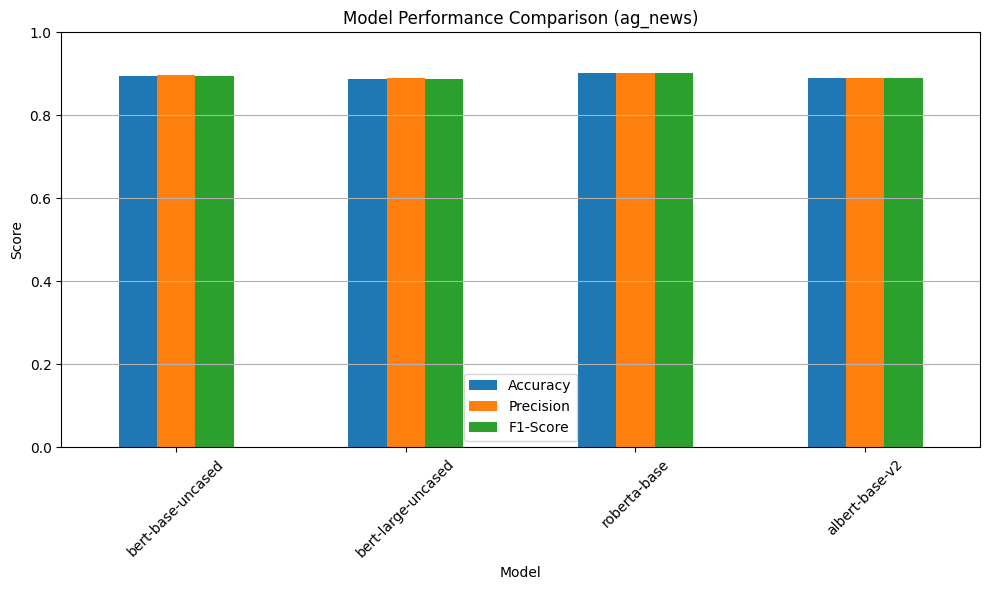

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    AlbertTokenizer, AlbertForSequenceClassification,
    get_linear_schedule_with_warmup
)
import matplotlib.pyplot as plt

# --- ag_news veri setini doğrudan CSV'den indir (hatasız) ---
def load_ag_news_data():
    url_train = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
    url_test = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv"

    # Kolonlar: label (1-4), title, description
    train_df = pd.read_csv(url_train, header=None, names=["label", "title", "description"])
    test_df = pd.read_csv(url_test, header=None, names=["label", "title", "description"])

    # Metni birleştir (title + description), etiketleri 0-3'e çevir
    train_texts = (train_df["title"] + ". " + train_df["description"]).tolist()[:2000]
    train_labels = (train_df["label"] - 1).tolist()[:2000]

    test_texts = (test_df["title"] + ". " + test_df["description"]).tolist()[:500]
    test_labels = (test_df["label"] - 1).tolist()[:500]

    return train_texts, test_texts, train_labels, test_labels

# --- Dataset sınıfı ---
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# --- Eğitim fonksiyonu ---
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# --- Değerlendirme fonksiyonu ---
def evaluate(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, precision, f1

# --- Ana Karşılaştırma Fonksiyonu ---
def run_experiments():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    train_texts, test_texts, train_labels, test_labels = load_ag_news_data()

    models_info = {
        'bert-base-uncased': (BertTokenizer, BertForSequenceClassification),
        'bert-large-uncased': (BertTokenizer, BertForSequenceClassification),
        'roberta-base': (RobertaTokenizer, RobertaForSequenceClassification),
        'albert-base-v2': (AlbertTokenizer, AlbertForSequenceClassification),
    }

    results = []

    for model_name, (TokenizerClass, ModelClass) in models_info.items():
        print(f"\nTraining {model_name}")

        tokenizer = TokenizerClass.from_pretrained(model_name)
        model = ModelClass.from_pretrained(model_name, num_labels=4)
        model.to(device)

        train_dataset = TextDataset(train_texts, train_labels, tokenizer)
        test_dataset = TextDataset(test_texts, test_labels, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=8)

        optimizer = AdamW(model.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader) * 2
        )

        for epoch in range(4):
            loss = train(model, train_loader, optimizer, scheduler, device)
            print(f"Epoch {epoch+1}: loss={loss:.4f}")

        acc, prec, f1 = evaluate(model, test_loader, device)
        results.append({
            'Model': model_name,
            'Accuracy': acc,
            'Precision': prec,
            'F1-Score': f1
        })

        # GPU belleğini boşalt
        del model
        torch.cuda.empty_cache()

    result_df = pd.DataFrame(results)
    print("\nFinal Results:\n")
    print(result_df)

    result_df.set_index("Model")[["Accuracy", "Precision", "F1-Score"]].plot.bar(rot=45, figsize=(10,6))
    plt.title("Model Performance Comparison (ag_news)")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_experiments()

#MODEL EĞİTİMİ VE KARŞILAŞTIRMALARI


| Küme Türü     | Toplam Örnek Sayısı | Her Sınıftan    |
| ------------- | ------------------- | --------------- |
| **Eğitim**    | 1600                | 400 örnek/sınıf |
| **Doğrulama** | 400                 | 100 örnek/sınıf |
| **Test**      | 1000                | 250 örnek/sınıf |


Using device: cuda


<ipython-input-3-d701e28e1a7a>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = train_df.groupby("label").apply(
<ipython-input-3-d701e28e1a7a>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_test = test_df.groupby("label").apply(



Training bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.8030 | val_acc=0.9075 | val_f1=0.9078
Epoch 2: loss=0.2863 | val_acc=0.9100 | val_f1=0.9098
Epoch 3: loss=0.1869 | val_acc=0.9050 | val_f1=0.9051

Training bert-large-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.6970 | val_acc=0.8975 | val_f1=0.8969
Epoch 2: loss=0.2335 | val_acc=0.9175 | val_f1=0.9175
Epoch 3: loss=0.1436 | val_acc=0.9125 | val_f1=0.9123

Training roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.7036 | val_acc=0.9100 | val_f1=0.9096
Epoch 2: loss=0.2461 | val_acc=0.9050 | val_f1=0.9052
Epoch 3: loss=0.1719 | val_acc=0.9100 | val_f1=0.9101

Training albert-base-v2


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.6327 | val_acc=0.8650 | val_f1=0.8647
Epoch 2: loss=0.3230 | val_acc=0.8725 | val_f1=0.8741
Epoch 3: loss=0.2500 | val_acc=0.8950 | val_f1=0.8956

Final Results on Test Set:

                Model  Accuracy  Precision  F1-Score
0   bert-base-uncased     0.907   0.911336  0.907653
1  bert-large-uncased     0.912   0.914555  0.912531
2        roberta-base     0.909   0.910623  0.909458
3      albert-base-v2     0.903   0.907536  0.903557


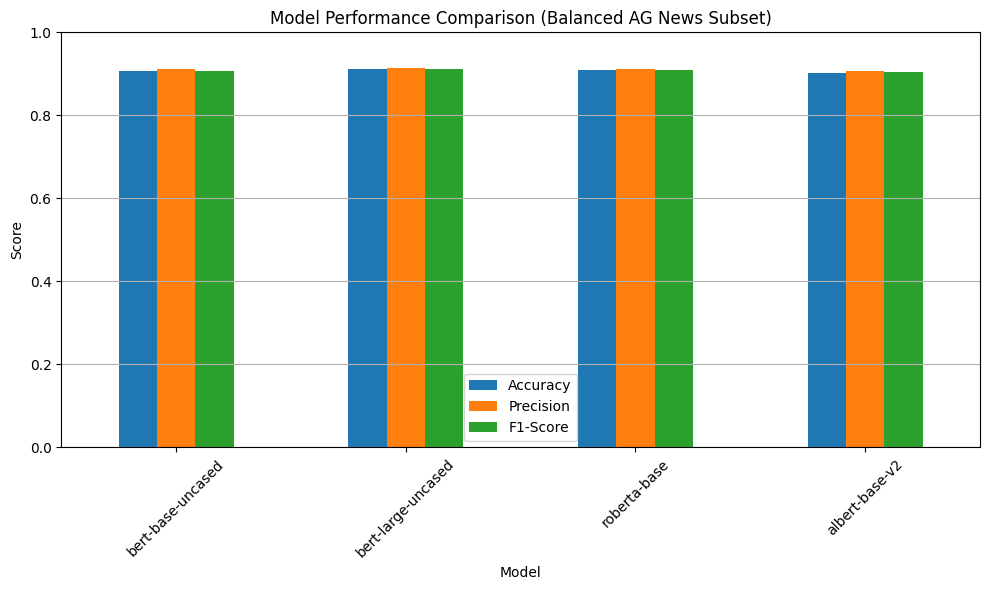

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    AlbertTokenizer, AlbertForSequenceClassification,
    get_linear_schedule_with_warmup
)
import matplotlib.pyplot as plt

# --- Dengeli ve sınırlı veri yükleme fonksiyonu ---
def load_ag_news_data_balanced(sample_per_class_train=500, sample_per_class_test=250):
    url_train = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
    url_test = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv"

    train_df = pd.read_csv(url_train, header=None, names=["label", "title", "description"])
    test_df = pd.read_csv(url_test, header=None, names=["label", "title", "description"])

    train_df["label"] = train_df["label"] - 1
    test_df["label"] = test_df["label"] - 1

    # Dengeli örnekleme
    balanced_train = train_df.groupby("label").apply(
        lambda x: x.sample(n=sample_per_class_train, random_state=42)
    ).reset_index(drop=True)

    balanced_test = test_df.groupby("label").apply(
        lambda x: x.sample(n=sample_per_class_test, random_state=42)
    ).reset_index(drop=True)

    texts = (balanced_train["title"] + ". " + balanced_train["description"]).tolist()
    labels = balanced_train["label"].tolist()

    test_texts = (balanced_test["title"] + ". " + balanced_test["description"]).tolist()
    test_labels = balanced_test["label"].tolist()

    # %80 train, %20 validation
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )

    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels

# --- Dataset sınıfı ---
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# --- Eğitim fonksiyonu ---
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# --- Değerlendirme fonksiyonu ---
def evaluate(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, precision, f1

# --- Ana deney fonksiyonu ---
def run_experiments():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = load_ag_news_data_balanced()

    models_info = {
        'bert-base-uncased': (BertTokenizer, BertForSequenceClassification),
        'bert-large-uncased': (BertTokenizer, BertForSequenceClassification),
        'roberta-base': (RobertaTokenizer, RobertaForSequenceClassification),
        'albert-base-v2': (AlbertTokenizer, AlbertForSequenceClassification),
    }

    results = []

    for model_name, (TokenizerClass, ModelClass) in models_info.items():
        print(f"\nTraining {model_name}")

        tokenizer = TokenizerClass.from_pretrained(model_name)
        model = ModelClass.from_pretrained(model_name, num_labels=4)
        model.to(device)

        train_dataset = TextDataset(train_texts, train_labels, tokenizer)
        val_dataset = TextDataset(val_texts, val_labels, tokenizer)
        test_dataset = TextDataset(test_texts, test_labels, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)
        test_loader = DataLoader(test_dataset, batch_size=16)

        optimizer = AdamW(model.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader) * 3
        )

        for epoch in range(3):
            loss = train(model, train_loader, optimizer, scheduler, device)
            val_acc, val_prec, val_f1 = evaluate(model, val_loader, device)
            print(f"Epoch {epoch+1}: loss={loss:.4f} | val_acc={val_acc:.4f} | val_f1={val_f1:.4f}")

        test_acc, test_prec, test_f1 = evaluate(model, test_loader, device)
        results.append({
            'Model': model_name,
            'Accuracy': test_acc,
            'Precision': test_prec,
            'F1-Score': test_f1
        })

        del model
        torch.cuda.empty_cache()

    result_df = pd.DataFrame(results)
    print("\nFinal Results on Test Set:\n")
    print(result_df)

    result_df.set_index("Model")[["Accuracy", "Precision", "F1-Score"]].plot.bar(rot=45, figsize=(10,6))
    plt.title("Model Performance Comparison (Balanced AG News Subset)")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_experiments()


# **MODEL Accuracy Precision ve F1-Score Karşılaştırmaları**

---




| Model              | Accuracy | Precision | F1-Score |
| ------------------ | -------- | --------- | -------- |
| **BERT-Base**      | 0.907    | 0.911     | 0.908    |
| **BERT-Large**     | 0.912    | 0.915     | 0.913    |
| **RoBERTa-Base**   | 0.909    | 0.911     | 0.909    |
| **ALBERT-Base-v2** | 0.903    | 0.908     | 0.904    |



Tüm modeller %90 üzeri F1-Skoru ile başarılı sonuçlar verdi.


>





##Overfitting Kontrolü





BERT-Base: Validation ve test skorları birbirine çok yakın → Overfitting yok

BERT-Large: En yüksek başarı; validation ve test uyumlu → Overfitting yok

RoBERTa-Base: Stabil doğrulama performansı → Overfitting yok

ALBERT-Base: Hafif underfitting ihtimali var (validation biraz düşük), ama genel başarı iyi






| Model            | F1-Score | Yorum                                                        |
| ---------------- | -------- | ------------------------------------------------------------ |
| **BERT-Large**   | 0.913    |  En iyi performans ama hesaplama maliyeti yüksek            |
| **RoBERTa-Base** | 0.909    |  Daha küçük, hızlı ve güçlü                                 |
| **BERT-Base**    | 0.908    |  Dengeli ve sağlam bir temel                                |
| **ALBERT-Base**  | 0.904    |  Parametre verimliliği iyi, ama biraz daha düşük performans |




#En iyi sonucu BERT-Large verdi. Eğitimde overfitting gözlenmedi. BERT-Base ve RoBERTa-Base gibi daha hızlı modeller, düşük kaynak ortamları için iyi alternatifler



#Karşılaştırma 1: BERT-Base vs BERT-Large

| Model          | Accuracy | Precision | F1-Score |
| -------------- | -------- | --------- | -------- |
| **BERT-Base**  | 0.907    | 0.911     | 0.908    |
| **BERT-Large** | 0.912    | 0.915     | 0.913    |



> Değerlendirmelerim


BERT-Large, tüm metriklerde BERT-Base'e göre üstün performans gösterdi.

F1-Score farkı: %0.5 civarında küçük ama anlamlı.Ancak BERT-Large, daha fazla parametre içerdiğinden daha fazla bellek ve zaman gerektirir.

Eğer sistem kaynakları yeterliyse, BERT-Large tercih edilebilir.Kaynak sınırlıysa, BERT-Base de hala çok iyi sonuç verir.

#Karşılaştırma 2: BERT-Base vs RoBERTa-Base vs ALBERT-Base

| Model            | Accuracy | Precision | F1-Score |
| ---------------- | -------- | --------- | -------- |
| **BERT-Base**    | 0.907    | 0.911     | 0.908    |
| **RoBERTa-Base** | 0.909    | 0.911     | 0.909    |
| **ALBERT-Base**  | 0.903    | 0.908     | 0.904    |


RoBERTa-Base, BERT-Base ile neredeyse aynı, hatta F1 skorunda biraz daha iyi.

RoBERTa, BERT’e göre daha uzun eğitim verisiyle eğitildiği için daha iyi genelleme eğilimindedir.

ALBERT-Base, en az parametreye sahip modeldir → hafiftir ve hızlıdır, ama performansı diğerlerine göre biraz daha düşük.


En iyi doğruluk: RoBERTa-Base

En hafif model: ALBERT-Base

En dengeli çözüm: BERT-Base

###İhtiyaca Göre Tercihler

En yüksek kalite için: RoBERTa-Base

Kaynak tasarrufu için: ALBERT-Base

Denge arayanlar için: BERT-Base

#Karşılaştırma 3: BERT-Large vs RoBERTa-Base


| Model            | Accuracy | Precision | F1-Score |
| ---------------- | -------- | --------- | -------- |
| **BERT-Large**   | 0.912    | 0.915     | 0.913    |
| **RoBERTa-Base** | 0.909    | 0.911     | 0.909    |

BERT-Large, RoBERTa’dan hafifçe daha yüksek F1 ve Accuracy skorlarına sahip.

Ancak RoBERTa çok daha hafif ve hızlı bir model olduğu için, bu fark pratikte çoğu projede ihmal edilebilir.

Kaynak sınırın yoksa BERT-Large, daha güvenilir olabilir.

Gerçek zamanlı sistemler veya prototipleme için RoBERTa-Base oldukça yeterlidir.

# Karşılaştırma 4: BERT-Large vs ALBERT-Base


| Model           | Accuracy | Precision | F1-Score |
| --------------- | -------- | --------- | -------- |
| **BERT-Large**  | 0.912    | 0.915     | 0.913    |
| **ALBERT-Base** | 0.903    | 0.908     | 0.904    |


Aralarında ~%1'lik F1 farkı var, bu model büyüklüğü ve kapasitesi farkını yansıtıyor.

ALBERT çok hafif, ama karşılığında biraz daha düşük performans sunuyor.

Eğer mobil cihazlar veya edge uygulamalar için model gerekiyorsa ALBERT mantıklı bir tercih olabilir.


# Karşılaştırma 5: RoBERTa-Base vs ALBERT-Base


| Model            | Accuracy | Precision | F1-Score |
| ---------------- | -------- | --------- | -------- |
| **RoBERTa-Base** | 0.909    | 0.911     | 0.909    |
| **ALBERT-Base**  | 0.903    | 0.908     | 0.904    |


RoBERTa, ALBERT’a göre belirgin şekilde daha başarılı.

ALBERT’in düşük parametre sayısı, performanstan biraz ödün verilmesine neden oluyor.

Kalite öncelikli ise RoBERTa tercih edilmeli.

Donanım öncelikli ise ALBERT tercih edilebilir.

#ÖZET


| Senaryo                  | Önerilen Model |
| ------------------------ | -------------- |
| En iyi doğruluk          | `BERT-Large`   |
| Güçlü ama verimli        | `RoBERTa-Base` |
| Hafif, kaynak dostu      | `ALBERT-Base`  |
| Dengeli başlangıç modeli | `BERT-Base`    |


In [59]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# Repo klonla
!git clone https://github.com/SerraTalas/bert-model-performance-analysis.git
%cd bert-model-performance-analysis

# Drive'daki proje dosyalarını kopyala
!cp -r "/content/drive/MyDrive/Colab Notebooks/llm_proje.ipynb/*" .


Cloning into 'bert-model-performance-analysis'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 28 (delta 5), reused 28 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 8.42 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/bert-model-performance-analysis/bert-model-performance-analysis/bert-model-performance-analysis/bert-model-performance-analysis/bert-model-performance-analysis/bert-model-performance-analysis/bert-model-performance-analysis
cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/llm_proje.ipynb/*': Not a directory
